In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl
import keras
from keras.models import Sequential
from keras.layers import Dense

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder

Using TensorFlow backend.


In [2]:
#Read
df = pd.read_csv('data/movie_all.tsv', delimiter='\t', encoding='ISO-8859-1')


In [3]:
#Poor way of cleaning up.
indexes = df[ df['genre'].str.find('Adult') != -1 ].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'].str.find('News') != -1 ].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'].str.find('Talk-Show') != -1 ].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'].str.find('Game-Show') != -1 ].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'].str.find('Reality-TV') != -1 ].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'].str.find('Film-Noir') != -1 ].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'].str.find('Musical') != -1 ].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'].str.find('Music') != -1 ].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'].str.find('Documentary') != -1 ].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'].str.find('Biography') != -1 ].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'].str.find('Sport') != -1 ].index
df.drop(indexes, inplace=True)

df['genre'] = df['genre'].str.replace('Short,', '')
df['genre'] = df['genre'].str.replace('Short', '')
df['genre'] = df['genre'].str.replace('Family,', '')
df['genre'] = df['genre'].str.replace('Family', '')
df = df[ df['genre'] != ""]
df['genre'] = df['genre'].str.replace('History', 'War')
df['genre'] = df['genre'].str.replace('Sport', 'Drama')
df['genre'] = df['genre'].str.replace('War', 'Action')
df['genre'] = df['genre'].str.replace('Sci-Fi', 'Fantasy')
df['genre'] = df['genre'].str.replace('Western', 'Action')
df['genre'] = df['genre'].str.replace('Crime', 'Drama')
df['genre'] = df['genre'].str.replace('Mystery', 'Thriller')
#df['genre'] = df['genre'].str.replace('Adventure', 'Action')

In [4]:
ser = pd.Series(df['genre'].str.split(','))
for index, lis in enumerate(ser):
    if lis[len(lis)-1] == "":
        lis = lis[:len(lis)-1]
    ser.iat[index] = pd.unique(lis)[:3]

In [5]:
df['genre'] = ser
df = df[df['genre'].str.len() > 1]
df.head()

,title,genre
10,GÃ¸ngehÃ¸vdingen,"[Drama, Action]"
13,Camille,"[Drama, Romance]"
19,Valdemar Sejr,"[Drama, Action]"
20,Amor fatal,"[Drama, Romance]"
39,Anny - Story of a Prostitute,"[Drama, Romance]"


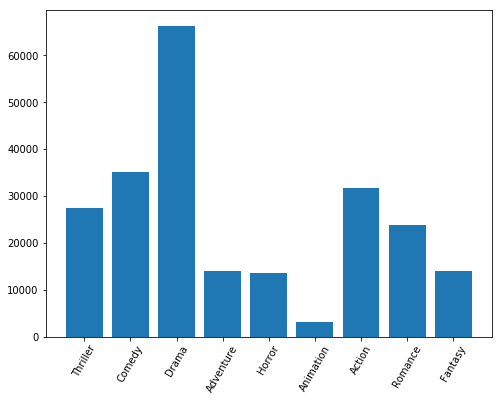

In [6]:
#Majority of movies are comedy, documentary or drama apparently.

fig = plt.figure(figsize=(8,6))
genreC = {}
for genres in df.genre:
    for genre in genres:
        try:
            genreC[genre] = genreC[genre] + 1
        except KeyError:
            genreC[genre] = 0

plt.bar(list(genreC.keys()), list(genreC.values()))
plt.xticks(rotation=60)
plt.show()

In [7]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['top3_acc']
    val_acc = history.history['val_top3_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [8]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding='ISO-8859-1') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [9]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MultiLabelBinarizer
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, Dropout, Conv1D
import io
import json

mlb = MultiLabelBinarizer()
mlb.fit(df.genre)
labels = mlb.classes_
print(labels)

embedding_dim=50
maxlen = 10

num_classes = len(genreC)
tokenizer = Tokenizer(lower=True)
tokenizer.fit_on_texts(df.title)
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

tokenizer_json = tokenizer.to_json()
with io.open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))
    
embedding_matrix = create_embedding_matrix('data/glove.6B.50d.txt', tokenizer.word_index, embedding_dim)

nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print(nonzero_elements / vocab_size)

import functools
top3_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=3)

top3_acc.__name__ = 'top3_acc'

def get_features(text_series):
    sequences = tokenizer.texts_to_sequences(text_series)
    return pad_sequences(sequences, maxlen=maxlen)

def prediction_to_label(prediction):
    tag_prob = [(labels[i], prob) for i, prob in enumerate(prediction.tolist())]
    return dict(sorted(tag_prob, key=lambda kv: kv[1], reverse=True))
    
def baseline():
    model = Sequential()
    model.add(Dense(num_classes, input_dim=maxlen, activation='relu'))
    model.add(Dense(num_classes, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[top3_acc])
    return model

def conv1d():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(Conv1D(128, 4, activation='relu', strides=1))
    model.add(GlobalMaxPool1D())
    model.add(Dense(num_classes, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[top3_acc])
    return model

def conv1d_embed():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=False))
    model.add(Dropout(0.1))
    model.add(Conv1D(128, 4, activation='relu', strides=1))
    model.add(GlobalMaxPool1D())
    model.add(Dense(num_classes))
    model.add(Activation('sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[top3_acc])
    return model

def conv1d_embed_train():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=True))
    #model.add(Dropout(0.1))
    model.add(Conv1D(128, 4, activation='relu', strides=1))
    model.add(GlobalMaxPool1D())
    model.add(Dense(num_classes))
    model.add(Activation('sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[top3_acc])
    return model


['Action' 'Adventure' 'Animation' 'Comedy' 'Drama' 'Fantasy' 'Horror'
 'Romance' 'Thriller']
39203
0.6755095273320919


In [10]:
x = get_features(df.title)
y = mlb.transform(df.genre)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=5000)

In [11]:
countGenres = 0
for genres in df.genre:
    countGenres = countGenres + len(genres)

class_weights = {}
for index, label in enumerate(labels):
    class_weights[index] = countGenres/genreC[label]
    print(label + " " + str(countGenres/genreC[label]))


Action 7.230606710393542
Adventure 16.463024124066628
Animation 73.37504
Comedy 6.507833342793893
Drama 3.4591548870819318
Fantasy 16.270276023557795
Horror 16.827902539263174
Romance 9.597229198057928
Thriller 8.371253331386221


Train on 69917 samples, validate on 29965 samples
Epoch 1/3
 - 30s - loss: 4.1215 - top3_acc: 0.7027 - val_loss: 0.4600 - val_top3_acc: 0.6790
Epoch 2/3
 - 28s - loss: 3.7973 - top3_acc: 0.7371 - val_loss: 0.4625 - val_top3_acc: 0.7256
Epoch 3/3
 - 28s - loss: 3.4803 - top3_acc: 0.7642 - val_loss: 0.4649 - val_top3_acc: 0.7094


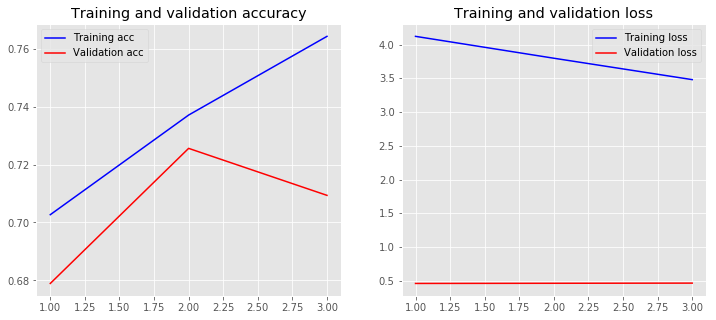

In [22]:
model = conv1d_embed_train()
callbacks = [
    #EarlyStopping(patience=3, monitor='val_loss'),
    #ModelCheckpoint(filepath='model_conv1d.h5', save_best_only=True)
]
history = model.fit(x_train, y_train,
                    class_weight=class_weights,
                    epochs=3,
                    batch_size=32, verbose=2,
                    validation_data=(x_test, y_test),
                    callbacks=callbacks)
plot_history(history)


In [23]:
#conv1d_model = keras.models.load_model('model_conv1d_test.h5')
#print(model.evaluate(x_test, y_test))


f = get_features(["Bee Movie"])
print(f)
p1 = prediction_to_label(model.predict(f)[0])
# p2 = prediction_to_label(modelEmb.predict(f)[0])
# p3 = prediction_to_label(modelEmbTrain.predict(f)[0])
print(p1)

top1 = max(p1, key=p1.get)
del p1[top1]
top2 = max(p1, key=p1.get)
del p1[top2]
top3 = max(p1, key=p1.get)
print(top1)
print(top2)
print(top3)
# df_t = pd.DataFrame()
# df_t['label'] = p1.keys()
# df_t['p_conv'] = p1.values()
# df_t.sort_values(by='p_conv', ascending=False)

[[   0    0    0    0    0    0    0    0 1759   40]]
{'Comedy': 0.9021897315979004, 'Horror': 0.09036070853471756, 'Drama': 0.11367838084697723, 'Adventure': 0.2737257182598114, 'Thriller': 0.03847857564687729, 'Animation': 0.7300567030906677, 'Action': 0.04450226575136185, 'Romance': 0.08890041708946228, 'Fantasy': 0.11962294578552246}
Comedy
Animation
Adventure


In [24]:
model.save('model_conv_big.h5')